<H3> <b>Capstone Project: London Districts and Schools </b></H3>

Importing the necessary libraries:

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup # website scraping library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  10.07 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  34.78 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  42.56 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.41 MB/s
Libraries imported.


<b>1. Downloading London postcode districts data:  </b>

London postcodes data taken from: <ahref>https://www.doogal.co.uk/london_postcodes.php</ahref>

In [119]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_02dcb41240ef4499939fbc856c75a1a6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='agG_nc-HtwKV5EH2Kn0tgXgLvtVlTLjSxpVEVVOz1bQn',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_02dcb41240ef4499939fbc856c75a1a6.get_object(Bucket='kclustering-donotdelete-pr-ce0zjcukojs0ji',Key='London_districts.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

london = pd.read_csv(body)
london.head()



District Postcode district                       Name  \
0  Eastern                E1      Mile End; Whitechapel   
1  Eastern                E2  Bethnal Green; Shoreditch   
2  Eastern                E3                        Bow   
3  Eastern                E4                  Chingford   
4  Eastern                E5                    Clapton   

                   District name   Latitude  Longitude  
0      E1: Mile End; Whitechapel  51.512497  -0.052098  
1  E2: Bethnal Green; Shoreditch  51.530300  -0.056163  
2                        E3: Bow  51.530230  -0.028907  
3                  E4: Chingford  51.633250   0.008156  
4                    E5: Clapton  51.557186  -0.049165

In [120]:
london.shape # should return 33: 32 districts plus The City of London

(125, 6)

In [121]:
print('The dataframe has {} postal districts.'.format(len(london['District name'].unique())))


The dataframe has 125 postal districts.


<b>2. Exploration and analysis of London postcode districts using Foursquare API.</b>

In [122]:
CLIENT_ID = '040LSTVVO3CPZA4413N4WB0N3O5P13OSBONDWRBLPFCIF0AT' # Foursquare ID
CLIENT_SECRET = 'WJ44KEYBCRKQDV1TR53SN4VN0GPKSLX2S2UG5GUC5CLJY3J2' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 040LSTVVO3CPZA4413N4WB0N3O5P13OSBONDWRBLPFCIF0AT
CLIENT_SECRET:WJ44KEYBCRKQDV1TR53SN4VN0GPKSLX2S2UG5GUC5CLJY3J2


In [123]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [124]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(london['Latitude'], london['Longitude'], london['District name']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [125]:
# function that extracts the category of the venue from the Foursquare output
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [126]:
# Function to extract popular venues for all the districts 

LIMIT=50

def getNearbyVenues(names, latitudes, longitudes, radius=700):# Radius of 700m 
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District name', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [127]:
london_venues = getNearbyVenues(names=london['District name'],
                                   latitudes=london['Latitude'],
                                   longitudes=london['Longitude']
                                  )

E1: Mile End; Whitechapel
E2: Bethnal Green; Shoreditch
E3: Bow
E4: Chingford
E5: Clapton
E6: East Ham; Beckton
E7: Forest Gate; Upton Park
E8: Hackney
E9: Homerton
E10: Leyton
E11: Leytonstone
E12: Manor Park
E13: Plaistow
E14: Poplar; Isle of Dogs
E15: Stratford; West Ham
E16: Canning Town; North Woolwich
E17: Walthamstow
E18: Woodford and South Woodford
E20: Olympic Park
EC1: Barbican; Clerkenwell; Finsbury
EC2: Moorgate; Liverpool Street
EC3: Monument; Tower Hill
EC4: Fleet Street; St Paul's
N1: Barnsbury; Islington
N2: East Finchley
N3: Finchley Central
N4: Finsbury Park
N5: Highbury
N6: Highgate
N7: Holloway
N8: Hornsey
N9: Lower Edmonton
N10: Muswell Hill
N11: New Southgate
N12: North Finchley
N13: Palmers Green
N14: Southgate
N15: Seven Sisters
N16: Stoke Newington
N17: Tottenham
N18: Upper Edmonton
N19: Tufnell Park
N20: Whetstone
N21: Winchmore Hill
N22: Alexandra Palace; Wood Green
NW1: Camden Town
NW2: Cricklewood
NW3: Hampstead
NW4: Hendon
NW5: Kentish Town
NW6: Kilburn
NW

In [11]:
print(london_venues.shape) 
print(london_venues["District name"].nunique())# Foursquare has found this many different vanues

(3988, 7)
125


In [141]:
london_venues['Venue Category']

0                                            Pub
1                                            Pub
2                                  Grocery Store
3                             Turkish Restaurant
4                                           Café
5                              Indian Restaurant
6                                           Park
7                                    Event Space
8                                   Concert Hall
9                                           Park
10                                         Hotel
11                                 Grocery Store
12                                          Pool
13                                          Park
14                            Italian Restaurant
15                                         Hotel
16                                   Coffee Shop
17                          Gym / Fitness Center
18                                 Grocery Store
19                            Light Rail Station
20                  

In [142]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py35_0 conda-forge

wordcloud-1.4. 100% |################################| Time: 0:00:00   8.56 MB/s
Wordcloud is installed and imported!


In [143]:
stopwords = set(STOPWORDS)

In [150]:
# instantiate a word cloud object
ldn_venues_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
ldn_venues_wc.generate(' '.join(london_venues['Venue Category']))

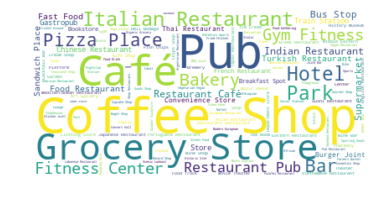

In [156]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# display the word cloud
plt.imshow(ldn_venues_wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('london_wx.pdf')

In [12]:
london_venues.groupby('District name').count()

District Latitude  District Longitude  \
District name                                                                 
E10: Leyton                                          23                  23   
E11: Leytonstone                                     31                  31   
E12: Manor Park                                       5                   5   
E13: Plaistow                                         9                   9   
E14: Popla; Isle of Dogs                             50                  50   
E15: Stratford; West Ham                             50                  50   
E16: Canning Town; North Woolwich                    44                  44   
E17: Walthamstow                                     50                  50   
E18: Woodford and South Woodford                     28                  28   
E1: Mile End; Whitechapel                            31                  31   
E20: Olympic Park                                    50                  50   
E2: Bethnal Green; Shoreditch                        50                  50   
E3: Bow                                              50                  50   
E4: Chingford                                        15                  15   
E5: Clapton                                          43                  43   
E6: East Ham; Beckton                                16                  16   
E7: Forest Gate; Upton Park                          12                  12   
E8: Hackney                                          50                  50   
E9: Homerton                                         39                  39   
EC1: Barbican; Clerkenwell; Finsbury                 50                  50   
EC2: Moorgate; Liverpool Street                      50                  50   
EC3: Monument; Tower Hill                            50                  50   
EC4: Fleet Street; St Paul's                         50                  50   
KT1: Kingston upon Thames                            50                  50   
KT4: Worcester Park                                  15                  15   
KT5: Surbiton                                        20                  20   
KT6: Surbiton                                        50                  50   
KT7: Thames Ditton                                    7                   7   
N10: Muswell Hill                                     8                   8   
N11: New Southgate                                   13                  13   
N12: North Finchley                                  37                  37   
N13: Palmers Green                                   39                  39   
N14: Southgate                                        5                   5   
N15: Seven Sisters                                   36                  36   
N16: Stoke Newington                                 42                  42   
N17: Tottenham                                       22                  22   
N18: Upper Edmonton                                   4                   4   
N19: Tufnell Park                                    19                  19   
N1: Barnsbury; Islington                             50                  50   
N20: Whetstone                                        4                   4   
N21: Winchmore Hill                                   9                   9   
N22: Alexandra Palace; Wood Green                    17                  17   
N2: East Finchley                                    34                  34   
N3: Finchley Central                                 33                  33   
N4: Finsbury Park                                    48                  48   
N5: Highbury                                         50                  50   
N6: Highgate                                         42                  42   
N7: Holloway                                         26                  26   
N8: Hornsey                                          43                  43   
N9: Lower

In [128]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [129]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
london_onehot['District name'] = london_venues['District name'] 

# move neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

District name  Accessories Store  African Restaurant  \
0  E1: Mile End; Whitechapel                  0                   0   
1  E1: Mile End; Whitechapel                  0                   0   
2  E1: Mile End; Whitechapel                  0                   0   
3  E1: Mile End; Whitechapel                  0                   0   
4  E1: Mile End; Whitechapel                  0                   0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0                    0             0         0       0                 0   
1                    0             0         0       0                 0   
2                    0             0         0       0                 0   
3                    0             0         0       0                 0   
4                    0             0         0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  Auto Garage  \
0                 0                   0                      0            0   
1                 0                   0                      0            0   
2                 0                   0                      0            0   
3                 0                   0                      0            0   
4                 0                   0                      0            0   

   BBQ Joint  Bagel Shop  Bakery  Bar  Baseball Field  Beach  Bed & Breakfast  \
0          0           0       0    0               0      0                0   
1          0           0       0    0               0      0                0   
2          0           0       0    0               0      0                0   
3          0           0       0    0               0      0                0   
4          0           0       0    0               0      0                0   

   Beer Bar  Beer Garden  Beer Store  Betting Shop  Bike Rental / Bike Share  \
0         0            0           0             0                         0   
1         0            0           0             0                         0   
2         0            0           0             0                         0   
3         0            0           0             0                         0   
4         0            0           0             0                         0   

   Bike Shop  Bistro  Boarding House  Boat or Ferry  Bookstore  \
0          0       0               0              0          0   
1          0       0               0              0          0   
2          0       0               0              0          0   
3          0       0               0              0          0   
4          0       0               0              0          0   

   Botanical Garden  Boutique  Bowling Alley  Boxing Gym  \
0                 0         0              0           0   
1                 0         0              0           0   
2                 0         0              0           0   
3                 0         0              0           0   
4                 0         0              0           0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  Bridge  \
0                     0               0        0            0       0   
1                     0               0        0            0       0   
2                     0               0        0            0       0   
3                     0               0        0            0       0   
4                     0               0        0            0       0   

   Bubble Tea Shop  Buddhist Temple  Bui

In [130]:
london_onehot.shape

(3999, 327)

In [131]:
london_grouped = london_onehot.groupby('District name').mean().reset_index()
london_grouped.head()

District name  Accessories Store  African Restaurant  \
0                E10: Leyton                0.0                 0.0   
1           E11: Leytonstone                0.0                 0.0   
2            E12: Manor Park                0.0                 0.0   
3              E13: Plaistow                0.0                 0.0   
4  E14: Poplar; Isle of Dogs                0.0                 0.0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0                  0.0           0.0       0.0     0.0               0.0   
1                  0.0           0.0       0.0     0.0               0.0   
2                  0.0           0.0       0.0     0.0               0.0   
3                  0.0           0.0       0.0     0.0               0.0   
4                  0.0           0.0       0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  Auto Garage  \
0              0.00                 0.0                    0.0          0.0   
1              0.00                 0.0                    0.0          0.0   
2              0.00                 0.0                    0.0          0.0   
3              0.00                 0.0                    0.0          0.0   
4              0.02                 0.0                    0.0          0.0   

   BBQ Joint  Bagel Shop    Bakery  Bar  Baseball Field  Beach  \
0       0.00         0.0  0.043478  0.0             0.0    0.0   
1       0.00         0.0  0.032258  0.0             0.0    0.0   
2       0.00         0.0  0.000000  0.0             0.0    0.0   
3       0.00         0.0  0.000000  0.0             0.0    0.0   
4       0.02         0.0  0.020000  0.0             0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0              0.0      0.00          0.0         0.0           0.0   
1              0.0      0.00          0.0         0.0           0.0   
2              0.0      0.00          0.0         0.0           0.0   
3              0.0      0.00          0.0         0.0           0.0   
4              0.0      0.02          0.0         0.0           0.0   

   Bike Rental / Bike Share  Bike Shop  Bistro  Boarding House  Boat or Ferry  \
0                       0.0        0.0     0.0             0.0            0.0   
1                       0.0        0.0     0.0             0.0            0.0   
2                       0.0        0.0     0.0             0.0            0.0   
3                       0.0        0.0     0.0             0.0            0.0   
4                       0.0        0.0     0.0             0.0            0.0   

   Bookstore  Botanical Garden  Boutique  Bowling Alley  Boxing Gym  \
0   0.043478               0.0       0.0            0.0         0.0   
1   0.000000               0.0       0.0            0.0         0.0   
2   0.000000               0.0       0.0            0.0         0.0   
3   0.000000               0.0       0.0            0.0         0.0   
4   0.020000               0.0       0.0            0.0         0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  Bridge  \
0                   0.0             0.0      0.0          0.0     0.0   
1                   0.0             0.0      0.0          0.0     0.0   
2                   0.0             0.0      0.0          0.0     0.0   
3                   0.0             0.0      0.0          0.0     0.0   
4                   0.0             0.0      0.0          0.0     0.0   

   Bubble Tea Shop  Buddhist

In [132]:
london_grouped.shape

(125, 327)

In [133]:
# Displaying top 5 most popular venues for each of the districts
num_top_venues = 5

for hood in london_grouped['District name']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['District name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----E10: Leyton----
           venue  freq
0            Pub  0.13
1  Grocery Store  0.13
2    Supermarket  0.09
3            Gym  0.09
4    Coffee Shop  0.09


----E11: Leytonstone----
                      venue  freq
0                      Café  0.13
1             Grocery Store  0.13
2                       Pub  0.10
3           Thai Restaurant  0.06
4  Mediterranean Restaurant  0.03


----E12: Manor Park----
                  venue  freq
0                   Pub   0.2
1         Train Station   0.2
2  Gym / Fitness Center   0.2
3            Restaurant   0.2
4     Indian Restaurant   0.2


----E13: Plaistow----
                  venue  freq
0              Bus Stop  0.22
1  Gym / Fitness Center  0.11
2                   Pub  0.11
3         Metro Station  0.11
4           Rugby Pitch  0.11


----E14: Poplar; Isle of Dogs----
                  venue  freq
0           Coffee Shop  0.06
1          Burger Joint  0.04
2  Gym / Fitness Center  0.04
3           Pizza Place  0.04
4    Italian Re

                 venue  freq
0    Indian Restaurant  0.12
1  Japanese Restaurant  0.06
2           Restaurant  0.06
3                 Café  0.06
4   Turkish Restaurant  0.06


----N4: Finsbury Park----
                venue  freq
0  Turkish Restaurant  0.25
1                Café  0.06
2         Coffee Shop  0.06
3                 Pub  0.04
4              Bakery  0.04


----N5: Highbury----
            venue  freq
0            Café  0.18
1             Pub  0.10
2       Wine Shop  0.04
3      Sports Bar  0.04
4  Soccer Stadium  0.04


----N6: Highgate----
                venue  freq
0                 Pub  0.26
1                Café  0.10
2              Bakery  0.05
3         Coffee Shop  0.05
4  Italian Restaurant  0.05


----N7: Holloway----
                  venue  freq
0                   Pub  0.12
1      Kebab Restaurant  0.08
2  Gym / Fitness Center  0.08
3     Convenience Store  0.08
4                Bakery  0.08


----N8: Hornsey----
                venue  freq
0                Ca

                  venue  freq
0         Grocery Store  0.11
1                  Park  0.05
2        Soccer Stadium  0.05
3       Thai Restaurant  0.05
4  Fast Food Restaurant  0.05


----SE8: Deptford----
                   venue  freq
0  Vietnamese Restaurant  0.20
1        Harbor / Marina  0.13
2                    Pub  0.13
3                   Park  0.13
4         Cosmetics Shop  0.07


----SE9: Eltham----
                      venue  freq
0          Department Store   0.1
1               Supermarket   0.1
2                  Pharmacy   0.1
3               Coffee Shop   0.1
4  Mediterranean Restaurant   0.1


----SW10: West Brompton----
                venue  freq
0                 Pub  0.10
1          Restaurant  0.10
2  Italian Restaurant  0.08
3                Café  0.06
4               Hotel  0.04


----SW11: Battersea----
          venue  freq
0          Café  0.10
1           Pub  0.06
2  Cocktail Bar  0.06
3  Burger Joint  0.06
4   Supermarket  0.04


----SW12: Balham----
     

In [134]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [135]:
# creating a dataframe with 10 most popular venues in each district
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['District name'] = london_grouped['District name']

for ind in np.arange(london_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

District name 1st Most Common Venue 2nd Most Common Venue  \
0                E10: Leyton                   Pub         Grocery Store   
1           E11: Leytonstone         Grocery Store                  Café   
2            E12: Manor Park  Gym / Fitness Center                   Pub   
3              E13: Plaistow              Bus Stop                   Pub   
4  E14: Poplar; Isle of Dogs           Coffee Shop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop                   Gym           Pizza Place   
1                   Pub       Thai Restaurant            Restaurant   
2     Indian Restaurant         Train Station            Restaurant   
3              Platform           Rugby Pitch         Metro Station   
4  Gym / Fitness Center                  Park            Food Truck   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Supermarket             Pet Store          Burger Joint   
1           Bus Station     Fish & Chips Shop  Fast Food Restaurant   
2        Farmers Market  Ethiopian Restaurant         Event Service   
3                  Café           Coffee Shop  Gym / Fitness Center   
4           Pizza Place                  Café          Burger Joint   

      9th Most Common Venue 10th Most Common Venue  
0        Chinese Restaurant              Bookstore  
1  Mediterranean Restaurant     Chinese Restaurant  
2               Event Space                Exhibit  
3               Flea Market            Flower Shop  
4             Smoothie Shop          Shopping Mall

In [136]:
borough_venues_sorted.shape

(125, 11)

<b>3. K-means clustering algorithm to classify districts by their most popular venues</b>

In [137]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('District name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2], dtype=int32)

In [138]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(borough_venues_sorted.set_index('District name'), on='District name')

london_merged.head()

District Postcode district                       Name  \
0  Eastern                E1      Mile End; Whitechapel   
1  Eastern                E2  Bethnal Green; Shoreditch   
2  Eastern                E3                        Bow   
3  Eastern                E4                  Chingford   
4  Eastern                E5                    Clapton   

                   District name   Latitude  Longitude  Cluster Labels  \
0      E1: Mile End; Whitechapel  51.512497  -0.052098               0   
1  E2: Bethnal Green; Shoreditch  51.530300  -0.056163               2   
2                        E3: Bow  51.530230  -0.028907               2   
3                  E4: Chingford  51.633250   0.008156               2   
4                    E5: Clapton  51.557186  -0.049165               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Park         Grocery Store                 Hotel   
1                   Pub           Coffee Shop          Cocktail Bar   
2                   Pub                  Café           Coffee Shop   
3                   Pub    Italian Restaurant           Coffee Shop   
4                   Pub                  Café           Coffee Shop   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                   Pub  Gym / Fitness Center    Italian Restaurant   
1                  Café               Brewery            Restaurant   
2         Grocery Store           Pizza Place                   Bar   
3                  Café                  Park         Grocery Store   
4         Grocery Store                  Park    Turkish Restaurant   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0    Turkish Restaurant                  Pool          Concert Hall   
1           Flower Shop              Wine Bar     Martial Arts Dojo   
2          Burger Joint              Bus Stop    Light Rail Station   
3                 Trail        History Museum    Athletics & Sports   
4    Italian Restaurant       Nature Preserve       Thai Restaurant   

  10th Most Common Venue  
0            Coffee Shop  
1                Gay Bar  
2              Locksmith  
3         Sandwich Place  
4             Beer Store

In [139]:
#  create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['District name'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

I believe the clustering algorithm with 7 clusters worked fairly well:
The central and suburb neighbourhoods are assigned different clusters, which is reasonable.

One thing which could be improved is taking a larger radius for remote locations and smaller radius for central locations.
At the moment, I believe the territories might overlap for some of the central neighbourhoods as the radius is 2km.

<b>4. Using Foursquare API to obtain data on schools and cluster the district based on the obtained data. </b>

The process is exactly the same as above, but instead of exploring the nearby venues the Foursquare searches for the nearby schools.

In [27]:
# function to extract schools for all districts
LIMIT=100
query='state school'

def getNearbySchools(names, latitudes, longitudes, radius=1000):
    
    schools_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            query)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        
        category=get_category_type(requests.get(url).json()["response"]['venues'][0])
        
          # return only relevant information for each nearby school
        schools_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'], 
            get_category_type(v)
            )
            for v in results]
            )

    nearby_schools = pd.DataFrame([item for schools_list in schools_list for item in schools_list])
    nearby_schools.columns = ['District name', 
                  'District Latitude', 
                  'District Longitude', 
                  'School', 
                  'School Latitude',
                  'School Longitude',
                  'School Type'
                  ]
    
    return(nearby_schools)

In [28]:
london_schools = getNearbySchools(names=london['District name'],
                                   latitudes=london['Latitude'],
                                   longitudes=london['Longitude']
                                  )

E1: Mile End; Whitechapel
E2: Bethnal Green; Shoreditch
E3: Bow
E4: Chingford
E5: Clapton
E6: East Ham; Beckton
E7: Forest Gate; Upton Park
E8: Hackney
E9: Homerton
E10: Leyton
E11: Leytonstone
E12: Manor Park
E13: Plaistow
E14: Popla; Isle of Dogs
E15: Stratford; West Ham
E16: Canning Town; North Woolwich
E17: Walthamstow
E18: Woodford and South Woodford
E20: Olympic Park
EC1: Barbican; Clerkenwell; Finsbury
EC2: Moorgate; Liverpool Street
EC3: Monument; Tower Hill
EC4: Fleet Street; St Paul's
N1: Barnsbury; Islington
N2: East Finchley
N3: Finchley Central
N4: Finsbury Park
N5: Highbury
N6: Highgate
N7: Holloway
N8: Hornsey
N9: Lower Edmonton
N10: Muswell Hill
N11: New Southgate
N12: North Finchley
N13: Palmers Green
N14: Southgate
N15: Seven Sisters
N16: Stoke Newington
N17: Tottenham
N18: Upper Edmonton
N19: Tufnell Park
N20: Whetstone
N21: Winchmore Hill
N22: Alexandra Palace; Wood Green
NW1: Camden Town
NW2: Cricklewood
NW3: Hampstead
NW4: Hendon
NW5: Kentish Town
NW6: Kilburn
NW7

In [29]:
london_schools.head()

District name  District Latitude  District Longitude  \
0  E1: Mile End; Whitechapel          51.512497           -0.052098   
1  E1: Mile End; Whitechapel          51.512497           -0.052098   
2  E1: Mile End; Whitechapel          51.512497           -0.052098   
3  E1: Mile End; Whitechapel          51.512497           -0.052098   
4  E1: Mile End; Whitechapel          51.512497           -0.052098   

                                              School  School Latitude  \
0        Bishop Challoner Catholic Collegiate School        51.513270   
1             St Mary And St Michael Catholic School        51.514044   
2                       Bigland Green Primary School        51.512776   
3  Barts and The London School of Medicine and De...        51.516950   
4                                   stateproperty.co        51.516314   

   School Longitude        School Type  
0         -0.051314        High School  
1         -0.052677  College Classroom  
2         -0.059266  Elementary School  
3         -0.060956     Medical School  
4         -0.065360     Clothing Store

In [30]:
london_schools.shape

(2020, 7)

In [31]:
london_schools.groupby('District name').count()

District Latitude  District Longitude  \
District name                                                                 
E10: Leyton                                          16                  16   
E11: Leytonstone                                      9                   9   
E12: Manor Park                                       6                   6   
E13: Plaistow                                         5                   5   
E14: Popla; Isle of Dogs                             20                  20   
E15: Stratford; West Ham                             12                  12   
E16: Canning Town; North Woolwich                     7                   7   
E17: Walthamstow                                     11                  11   
E18: Woodford and South Woodford                     10                  10   
E1: Mile End; Whitechapel                            35                  35   
E20: Olympic Park                                     8                   8   
E2: Bethnal Green; Shoreditch                        31                  31   
E3: Bow                                              19                  19   
E4: Chingford                                         5                   5   
E5: Clapton                                          15                  15   
E6: East Ham; Beckton                                 9                   9   
E7: Forest Gate; Upton Park                           9                   9   
E8: Hackney                                          20                  20   
E9: Homerton                                          1                   1   
EC1: Barbican; Clerkenwell; Finsbury                 50                  50   
EC2: Moorgate; Liverpool Street                      50                  50   
EC3: Monument; Tower Hill                            50                  50   
EC4: Fleet Street; St Paul's                         50                  50   
KT1: Kingston upon Thames                            16                  16   
KT4: Worcester Park                                   4                   4   
KT5: Surbiton                                        14                  14   
KT6: Surbiton                                         7                   7   
KT7: Thames Ditton                                    8                   8   
N10: Muswell Hill                                    10                  10   
N11: New Southgate                                    6                   6   
N12: North Finchley                                  11                  11   
N13: Palmers Green                                    8                   8   
N14: Southgate                                       14                  14   
N15: Seven Sisters                                   17                  17   
N16: Stoke Newington                                 14                  14   
N17: Tottenham                                        4                   4   
N18: Upper Edmonton                                   9                   9   
N19: Tufnell Park                                    16                  16   
N1: Barnsbury; Islington                             40                  40   
N20: Whetstone                                        9                   9   
N21: Winchmore Hill                                   5                   5   
N22: Alexandra Palace; Wood Green                     5                   5   
N2: East Finchley                                     7                   7   
N3: Finchley Central                                 10                  10   
N4: Finsbury Park                                    13                  13   
N5: Highbury                                         29                  29   
N6: Highgate                                         12                  12   
N7: Holloway                                         30                  30   
N8: Hornsey                                          16                  16   
N9: Lower

In [32]:
# one hot encoding
london_onehot = pd.get_dummies(london_schools[['School Type']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
london_onehot['District name'] = london_schools['District name'] 

# move neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

District name  Adult Education Center  Art Gallery  Art Museum  \
0  E1: Mile End; Whitechapel                       0            0           0   
1  E1: Mile End; Whitechapel                       0            0           0   
2  E1: Mile End; Whitechapel                       0            0           0   
3  E1: Mile End; Whitechapel                       0            0           0   
4  E1: Mile End; Whitechapel                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Athletics & Sports  Bakery  \
0                    0                     0                   0       0   
1                    0                     0                   0       0   
2                    0                     0                   0       0   
3                    0                     0                   0       0   
4                    0                     0                   0       0   

   Bank  Bar  Basketball Court  Building  Bus Station  Bus Stop  \
0     0    0                 0         0            0         0   
1     0    0                 0         0            0         0   
2     0    0                 0         0            0         0   
3     0    0                 0         0            0         0   
4     0    0                 0         0            0         0   

   Business Center  Business Service  Café  Camera Store  Campground  Casino  \
0                0                 0     0             0           0       0   
1                0                 0     0             0           0       0   
2                0                 0     0             0           0       0   
3                0                 0     0             0           0       0   
4                0                 0     0             0           0       0   

   Chinese Restaurant  Chocolate Shop  Circus  Clothing Store  \
0                   0               0       0               0   
1                   0               0       0               0   
2                   0               0       0               0   
3                   0               0       0               0   
4                   0               0       0               1   

   College & University  College Academic Building  \
0                     0                          0   
1                     0                          0   
2                     0                          0   
3                     0                          0   
4                     0                          0   

   College Administrative Building  College Arts Building  College Auditorium  \
0                                0                      0                   0   
1                                0                      0                   0   
2                                0                      0                   0   
3                                0                      0                   0   
4                                0                      0                   0   

   College Cafeteria  College Classroom  College Communications Building  \
0                  0                  0                                0   
1                  0                  1                                0   
2                  0                  0                                0   
3                  0                  0                                0   
4                  0                  0                                0   

   College Engineering Building  College Gym  College Lab  College Library  \
0                             0            0            0                0   
1                             0            0            0                0   
2                             0            0            0                0   
3                             0            0            0                0   
4                             0            0            0                0   

   College Math Building  College Quad  College Rec Center

In [33]:
london_onehot.shape

(2020, 141)

In [34]:
london_grouped = london_onehot.groupby('District name').mean().reset_index()
london_grouped.head()

District name  Adult Education Center  Art Gallery  Art Museum  \
0               E10: Leyton                     0.0       0.0625         0.0   
1          E11: Leytonstone                     0.0       0.0000         0.0   
2           E12: Manor Park                     0.0       0.0000         0.0   
3             E13: Plaistow                     0.0       0.0000         0.0   
4  E14: Popla; Isle of Dogs                     0.0       0.0000         0.0   

   Arts & Crafts Store  Arts & Entertainment  Athletics & Sports  Bakery  \
0                  0.0                   0.0              0.0625     0.0   
1                  0.0                   0.0              0.0000     0.0   
2                  0.0                   0.0              0.0000     0.0   
3                  0.0                   0.0              0.0000     0.0   
4                  0.0                   0.0              0.0000     0.0   

   Bank  Bar  Basketball Court  Building  Bus Station  Bus Stop  \
0   0.0  0.0               0.0       0.0          0.0      0.00   
1   0.0  0.0               0.0       0.0          0.0      0.00   
2   0.0  0.0               0.0       0.0          0.0      0.00   
3   0.0  0.0               0.0       0.0          0.0      0.00   
4   0.0  0.0               0.0       0.0          0.0      0.05   

   Business Center  Business Service  Café  Camera Store  Campground  Casino  \
0              0.0          0.000000   0.0           0.0         0.0     0.0   
1              0.0          0.000000   0.0           0.0         0.0     0.0   
2              0.0          0.166667   0.0           0.0         0.0     0.0   
3              0.0          0.000000   0.0           0.0         0.0     0.0   
4              0.0          0.000000   0.0           0.0         0.0     0.0   

   Chinese Restaurant  Chocolate Shop  Circus  Clothing Store  \
0                 0.0             0.0     0.0             0.0   
1                 0.0             0.0     0.0             0.0   
2                 0.0             0.0     0.0             0.0   
3                 0.0             0.0     0.0             0.0   
4                 0.0             0.0     0.0             0.0   

   College & University  College Academic Building  \
0                   0.0                   0.187500   
1                   0.0                   0.111111   
2                   0.0                   0.000000   
3                   0.0                   0.200000   
4                   0.0                   0.100000   

   College Administrative Building  College Arts Building  College Auditorium  \
0                             0.00                 0.0625                0.00   
1                             0.00                 0.0000                0.00   
2                             0.00                 0.0000                0.00   
3                             0.00                 0.0000                0.00   
4                             0.05                 0.0000                0.05   

   College Cafeteria  College Classroom  College Communications Building  \
0                0.0                0.0                              0.0   
1                0.0                0.0                              0.0   
2                0.0                0.0                              0.0   
3                0.0                0.0                              0.0   
4                0.0                0.0                              0.0   

   College Engineering Building  College Gym  College Lab  College Library  \
0                           0.0          0.0          0.0           0.0625   
1                           0.0          0.0          0.0           0.0000   
2                           0.0          0.0          0.0           0.0000   
3                           0.0          0.0          0.0           0.0000   
4                           0.0          0.0          0.0           0.0000   

   College Math Building  College Quad  College Rec Center  \
0

In [35]:
london_grouped.shape

(125, 141)

In [36]:
# Displaying top 5 most popular schools for each of the neigbourhoods.
num_top_venues = 5

for hood in london_grouped['District name']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['District name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----E10: Leyton----
                       venue  freq
0                     School  0.25
1  College Academic Building  0.19
2          Elementary School  0.12
3            College Library  0.06
4      College Arts Building  0.06


----E11: Leytonstone----
                       venue  freq
0                     School  0.22
1          Elementary School  0.11
2  College Academic Building  0.11
3              Indie Theater  0.11
4              Middle School  0.11


----E12: Manor Park----
                          venue  freq
0                        School  0.17
1             Elementary School  0.17
2  General College & University  0.17
3              Business Service  0.17
4                Driving School  0.17


----E13: Plaistow----
                       venue  freq
0                     School   0.4
1                High School   0.2
2  College Academic Building   0.2
3     Adult Education Center   0.0
4             Medical Center   0.0


----E14: Popla; Isle of Dogs----
          

                          venue  freq
0  General College & University  0.25
1     College Academic Building  0.25
2             Mobile Phone Shop  0.00
3                Medical Center  0.00
4                Medical School  0.00


----N18: Upper Edmonton----
               venue  freq
0  Elementary School  0.33
1             School  0.22
2    Language School  0.11
3       Dance Studio  0.11
4     Driving School  0.11


----N19: Tufnell Park----
                          venue  freq
0                        School  0.25
1             Elementary School  0.19
2         College Arts Building  0.12
3  General College & University  0.06
4          Other Great Outdoors  0.06


----N1: Barnsbury; Islington----
                       venue  freq
0                     School  0.28
1          Elementary School  0.12
2            Language School  0.10
3  College Academic Building  0.08
4              Event Service  0.02


----N20: Whetstone----
                             venue  freq
0        Coll

                       venue  freq
0                High School  0.25
1          Elementary School  0.25
2  College Academic Building  0.12
3              Middle School  0.12
4             Driving School  0.12


----SE1: Bermondsey; Southwark; Waterloo----
                          venue  freq
0  General College & University  0.25
1                        School  0.25
2     College Academic Building  0.25
3                Driving School  0.25
4                 Middle School  0.00


----SE20: Anerley----
                    venue  freq
0       Elementary School  0.25
1                  School  0.25
2            Music School  0.25
3       College Classroom  0.25
4  Adult Education Center  0.00


----SE21: Dulwich----
                          venue  freq
0                Nursery School  0.22
1  General College & University  0.11
2             Elementary School  0.11
3                        School  0.11
4     College Academic Building  0.11


----SE22: East Dulwich----
                  

               venue  freq
0             School  0.43
1        High School  0.07
2     Driving School  0.07
3  Elementary School  0.07
4           Bus Stop  0.07


----SW9: Stockwell----
               venue  freq
0             School  0.55
1        High School  0.09
2  Elementary School  0.09
3            Library  0.00
4  Martial Arts Dojo  0.00


----W10: North Kensington----
               venue  freq
0  Elementary School  0.19
1             School  0.14
2        Yoga Studio  0.05
3           Building  0.05
4          Preschool  0.05


----W11: Notting Hill----
               venue  freq
0  Elementary School  0.24
1             School  0.12
2  College Cafeteria  0.09
3     Student Center  0.06
4     Nursery School  0.06


----W12: Shepherds Bush----
                       venue  freq
0                     School   0.4
1                College Lab   0.2
2  College Academic Building   0.2
3          Community College   0.2
4     Adult Education Center   0.0


----W13: West Ealing----


In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
# creating a dataframe with 5 most popular venues in each neighbourhood.
num_top_schools = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
schools_sorted = pd.DataFrame(columns=columns)
schools_sorted['District name'] = london_grouped['District name']

for ind in np.arange(london_grouped.shape[0]):
    schools_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_schools)

schools_sorted.head()

District name         1st Most Common Venue  \
0               E10: Leyton                        School   
1          E11: Leytonstone                        School   
2           E12: Manor Park  General College & University   
3             E13: Plaistow                        School   
4  E14: Popla; Isle of Dogs             Elementary School   

       2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
0  College Academic Building     Elementary School      College Arts Building   
1              Indie Theater     Elementary School                High School   
2           Business Service                School          Elementary School   
3  College Academic Building           High School                Yoga Studio   
4                     Office           High School  College Academic Building   

       5th Most Common Venue  
0                Art Gallery  
1  College Academic Building  
2             Driving School  
3          Convention Center  
4                     School

In [39]:
# set number of clusters
kclusters = 3

london_grouped_clustering = london_grouped.drop('District name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 2, 0, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 1, 2, 1, 0, 2, 2], dtype=int32)

In [40]:
# add clustering labels
schools_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(schools_sorted.set_index('District name'), on='District name')

london_merged.head()

District Postcode district                       Name  \
0  Eastern                E1      Mile End; Whitechapel   
1  Eastern                E2  Bethnal Green; Shoreditch   
2  Eastern                E3                        Bow   
3  Eastern                E4                  Chingford   
4  Eastern                E5                    Clapton   

                   District name   Latitude  Longitude  Cluster Labels  \
0      E1: Mile End; Whitechapel  51.512497  -0.052098               2   
1  E2: Bethnal Green; Shoreditch  51.530300  -0.056163               0   
2                        E3: Bow  51.530230  -0.028907               2   
3                  E4: Chingford  51.633250   0.008156               2   
4                    E5: Clapton  51.557186  -0.049165               1   

  1st Most Common Venue         2nd Most Common Venue  \
0        Medical School             Elementary School   
1                School             Elementary School   
2                School  General College & University   
3        Student Center                Nursery School   
4     Elementary School                        School   

          3rd Most Common Venue                     4th Most Common Venue  \
0                      Bus Stop                         Community College   
1  General College & University                         Community College   
2     College Academic Building           College Administrative Building   
3                   High School                         Elementary School   
4                   High School  Residential Building (Apartment / Condo)   

  5th Most Common Venue  
0  College & University  
1            Restaurant  
2           Art Gallery  
3    Miscellaneous Shop  
4        Nursery School

In [41]:
#  create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['District name'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Comment

<b> 5. Exploring a data set on schools from the Office of National Statistics.</b> 

Table 1:

In [42]:

body = client_02dcb41240ef4499939fbc856c75a1a6.get_object(Bucket='kclustering-donotdelete-pr-ce0zjcukojs0ji',Key='england_spine.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

all_schools = pd.read_csv(body)
all_schools.head()

URN   LA  ESTAB  LAESTAB                                    SCHNAME  \
0  100000  201   3614  2013614  Sir John Cass's Foundation Primary School   
1  100001  201   6005  2016005            City of London School for Girls   
2  100002  201   6006  2016006                 St Paul's Cathedral School   
3  100003  201   6007  2016007                      City of London School   
4  100008  202   2019  2022019                      Argyle Primary School   

  OTHERSCHNAME                 STREET      LOCALITY ADDRESS3    TOWN  \
0          NaN     St James's Passage  Duke's Place      NaN  London   
1          NaN      St Giles' Terrace      Barbican      NaN  London   
2          NaN           2 New Change           NaN      NaN  London   
3          NaN  Queen Victoria Street           NaN      NaN  London   
4          NaN       Tonbridge Street           NaN      NaN  London   

   POSTCODE        TELNUM  ICLOSE  OPENDATE  CLOSEDATE  ISNEW  \
0  EC3A 5DE  020 72831147       1       NaN        NaN      0   
1  EC2Y 8BB  020 78475500       1       NaN        NaN      0   
2  EC4M 9AD  020 72485156       1       NaN        NaN      0   
3  EC4V 3AL  020 36806300       1       NaN        NaN      0   
4  WC1H 9EG  020 78374590       1       NaN        NaN      0   

           MINORGROUP                    NFTYPE OTHERNFTYPE  ISPRIMARY  \
0   Maintained School    Voluntary aided school         NaN          1   
1  Independent School  Other independent school         NaN          1   
2  Independent School  Other independent school         NaN          1   
3  Independent School  Other independent school         NaN          1   
4   Maintained School          Community school         NaN          1   

   ISSECONDARY  ISPOST16  AGEL  AGEH GENDER SIXFGENDER           RELDENOM  \
0            0         0     3    11  Mixed      Mixed  Church of England   
1            1         1     7    18  Girls      Girls               None   
2            1         0     4    13  Mixed      Mixed  Church of England   
3            1         1    10    18   Boys       Boys               None   
4            0         0     3    11  Mixed      Mixed     Does not apply   

    ADMPOL  OTHERURN  NEWACFLAG  RE-BROKERED  
0  Unknown       NaN          6            0  
1  Unknown       NaN          6            0  
2  Unknown       NaN          6            0  
3  Unknown       NaN          6            0  
4  Unknown       NaN          6            0

In [43]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
all_schools.drop(['ESTAB','LAESTAB','OTHERSCHNAME','ADDRESS3','TELNUM','ICLOSE','OPENDATE','CLOSEDATE','ISNEW','OTHERNFTYPE','ISPOST16','ADMPOL','RE-BROKERED','NEWACFLAG'], axis=1, inplace=True)

In [44]:
all_schools.groupby('MINORGROUP').count()

URN     LA  SCHNAME  STREET  LOCALITY   TOWN  POSTCODE  \
MINORGROUP                                                                     
Academy              8124   8124     8124    8117      4154   8115      8123   
College               336    336      336     329       108    331       331   
Independent School   1899   1899     1899    1887       835   1895      1898   
Maintained School   13420  13420    13420   13411      7913  13412     13420   
Special School       1613   1613     1613    1608       861   1609      1613   

                    NFTYPE  ISPRIMARY  ISSECONDARY   AGEL   AGEH  GENDER  \
MINORGROUP                                                                 
Academy               8124       8124         8124   8124   8124    8124   
College                336        336          336    336    336     336   
Independent School    1899       1899         1899   1899   1899    1899   
Maintained School    13420      13420        13420  13420  13420   13420   
Special School        1613       1613         1613   1613   1613    1613   

                    SIXFGENDER  RELDENOM  OTHERURN  
MINORGROUP                                          
Academy                   8124      8124      1393  
College                    336       336        10  
Independent School        1899      1899         0  
Maintained School        13420     13420      1147  
Special School            1613      1613       107

In [45]:
all_schools.groupby('TOWN').count()

URN    LA  SCHNAME  STREET  LOCALITY  POSTCODE  \
TOWN                                                                           
Abberley                        1     1        1       1         0         1   
Abbots Langley                  5     5        5       5         1         5   
Abingdon                       37    37       37      37        16        37   
Accrington                     35    35       35      35        20        35   
Acklam                          1     1        1       1         0         1   
Addlestone                     12    12       12      12         3        12   
Adlington                       1     1        1       1         1         1   
Akrotiri                        1     1        1       1         0         0   
Albury                          1     1        1       1         0         1   
Alcester                       13    13       13      13         6        13   
Alconbury Weald                 1     1        1       1         0         1   
Aldeburgh                       1     1        1       1         0         1   
Alderley Edge                   4     4        4       4         1         4   
Aldershot                      11    11       11      11         2        11   
Alford                          6     6        6       6         3         6   
Alfreton                       34    34       34      34        27        34   
Almondsbury                     2     2        2       2         0         2   
Alnwick                        11    11       11      11         3        11   
Alresford                       6     6        6       6         1         6   
Alsager                         2     2        2       2         0         2   
Alston                          3     3        3       3         0         3   
Alton                          18    18       18      18         7        18   
Altrincham                     33    33       33      33        24        33   
Ambleside                       3     3        3       3         2         3   
Amersham                       21    21       21      21        10        21   
Amesbury                        1     1        1       1         1         1   
Ampthill                        1     1        1       1         0         1   
Andover                        38    38       38      38        11        38   
Appleby-in-Westmorland          6     6        6       6         0         6   
Arlesey                         2     2        2       2         0         2   
Arundel                         9     9        9       9         7         9   
Ascot                          17    17       17      17         8        17   
Ash                             4     4        4       4         0         4   
Ash Vale                        1     1        1       1         0         1   
Ashbourne                      25    25       25      25        17        25   
Ashburton                       2     2        2       2         0         2   
Ashby De La Zouch               1     1        1       1         0         1   
Ashby-de-la-Zouch               9     9        9       9         2         9   
Ashford                        62    62       62      62        36        62   
Ashington                      11    11       11      11         1        11   
Ashtead                         6     6        6       6         1         6   
Ashton Under Lyne               1     1        1       1         0         1   
Ashton-Under-Lyne               2     2        2       2         1         2   
Ashton-under-Lyne              28    28       28      28         5        28   
Askam-in-Furness                2     2        2       2         1         2   
Aspley Guise                    1     1        1       1         0         1   
Aston                           1     1        1       1         1         1   
Atherstone                     15    15       15      15         9        15   
Atherton                      

In [46]:
state_schools = all_schools[all_schools['MINORGROUP'] == 'Maintained School'] # only interested in state schools (Maintained schools)
state_schools=state_schools.reset_index()

In [47]:
state_schools.shape[0]

13420

In [48]:
outer_london_postcodes=('BR','CR','DA','EN','HA','IG','KT','RM','SM','TW','UB','WD')
state_schools['islondon']=0

for int in range(0,state_schools.shape[0]):

    area=state_schools['POSTCODE'][int][:2]

    if state_schools['TOWN'][int]=='London' or area in outer_london_postcodes:
        state_schools['islondon'][int]=1
        

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
state_schools.head()

index     URN   LA                                    SCHNAME  \
0      0  100000  201  Sir John Cass's Foundation Primary School   
1      4  100008  202                      Argyle Primary School   
2      5  100009  202                    Beckford Primary School   
3      6  100010  202                   Brecknock Primary School   
4      7  100011  202                  Brookfield Primary School   

               STREET        LOCALITY    TOWN  POSTCODE         MINORGROUP  \
0  St James's Passage    Duke's Place  London  EC3A 5DE  Maintained School   
1    Tonbridge Street             NaN  London  WC1H 9EG  Maintained School   
2     Dornfell Street  West Hampstead  London   NW6 1QL  Maintained School   
3        Cliff Villas             NaN  London   NW1 9AL  Maintained School   
4        Chester Road             NaN  London   N19 5DH  Maintained School   

                   NFTYPE  ISPRIMARY  ISSECONDARY  AGEL  AGEH GENDER  \
0  Voluntary aided school          1            0     3    11  Mixed   
1        Community school          1            0     3    11  Mixed   
2        Community school          1            0     3    11  Mixed   
3        Community school          1            0     2    11  Mixed   
4        Community school          1            0     3    11  Mixed   

  SIXFGENDER           RELDENOM  OTHERURN  islondon  
0      Mixed  Church of England       NaN         1  
1      Mixed     Does not apply       NaN         1  
2      Mixed     Does not apply       NaN         1  
3      Mixed     Does not apply       NaN         1  
4      Mixed     Does not apply       NaN         1

In [50]:
prim_state_schools = state_schools[state_schools['ISPRIMARY'] == 1] # only interested in schools which accept primary school students
prim_state_schools.shape

(12509, 19)

In [51]:
mixed_girls_schools=prim_state_schools[prim_state_schools['GENDER'] != 'Boys']# only interested in schools for girls or mixed

In [108]:
ldn_schools=mixed_girls_schools[mixed_girls_schools['islondon'] == 1]
print(ldn_schools.shape)

(1670, 19)


In [106]:
body = client_02dcb41240ef4499939fbc856c75a1a6.get_object(Bucket='kclustering-donotdelete-pr-ce0zjcukojs0ji',Key='london schools coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_loc = pd.read_csv(body)
df_loc.head()

Latitude  Longitude     URN
0  51.513685  -0.077478  100000
1  51.528800  -0.124104  100008
2  51.550700  -0.199510  100009
3  51.547500  -0.127854  100010
4  51.563600  -0.144350  100011

In [109]:
ldn_schools=ldn_schools.join(df_loc.set_index('URN'), on='URN')

In [110]:
ldn_schools=ldn_schools.reset_index(drop=True)

In [111]:
ldn_schools.shape

(1670, 21)

#Only ran the below code once to get the schools latitude and longitude values:

for int in range(1590,1600):
    address = ldn_schools['POSTCODE'][int]
    geolocator = Nominatim(user_agent="london_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    ldn_schools['Latitude'][int]=latitude
    ldn_schools['Longitude'][int]=longitude

In [117]:
# create map of London using latitude and longitude values

from folium.plugins import MarkerCluster
schools_london = folium.Map(location=[latitude, longitude], zoom_start=10) 
marker_cluster = MarkerCluster().add_to(schools_london)
    # add markers to map
for lat, lng, district in zip(ldn_schools['Latitude'], ldn_schools['Longitude'], ldn_schools['SCHNAME']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1600,#1 mile ~1600m
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(marker_cluster) 
schools_london

In [113]:
#downloading a file with ofsted school ratings
body = client_02dcb41240ef4499939fbc856c75a1a6.get_object(Bucket='kclustering-donotdelete-pr-ce0zjcukojs0ji',Key='england_ofsted-schools.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_rating = pd.read_csv(body)
df_rating.head()



URN  Overall effectiveness
0  139456                      3
1  109567                      2
2  105670                      2
3  110353                      2
4  126089                      2

In [114]:
ldn_schools=ldn_schools.join(df_rating.set_index('URN'), on='URN')

In [ ]:
#only leave schools with overall effectiveness of 1 ('Outstanding rating'):

In [115]:
outst_ldn_schools = ldn_schools[ldn_schools['Overall effectiveness'] == 1]
outst_ldn_schools.shape

(398, 22)

In [118]:
# create map of London using latitude and longitude values
outstanding_schools_london = folium.Map(location=[latitude, longitude], zoom_start=10) 
marker_cluster = MarkerCluster().add_to(outstanding_schools_london)
    # add markers to map
for lat, lng, district in zip(outst_ldn_schools['Latitude'], outst_ldn_schools['Longitude'], outst_ldn_schools['SCHNAME']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1000,#1 mile ~1600m
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(marker_cluster) 
    
outstanding_schools_london